# `river` Hyperparameter Tuning: Mondrian Tree Classifier with Bananas Data {#sec-river-amf-classifier-bananas}

This chapter demonstrates hyperparameter tuning for `river`'s `Mondrian Tree Classifier` with the bananas data set [[SOURCE]](https://riverml.xyz/0.19.0/api/datasets/Bananas/). 

## Setup {#sec-setup-13}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, size of the data set, and the experiment name.

* `MAX_TIME`: The maximum run time in seconds for the hyperparameter tuning process.
* `INIT_SIZE`: The initial design size for the hyperparameter tuning process.
* `PREFIX`: The prefix for the experiment name.
* `K`: The factor that determines the number of samples in the data set.

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `K` is the multiplier for the number of samples. If it is set to 1, then `100_000`samples are taken. It is set to 0.1 for demonstration purposes. For real experiments, this should be increased to at least 1.
:::


In [1]:
MAX_TIME = 1
INIT_SIZE = 1
PREFIX="52-river"

In [2]:
#| echo: false
import os
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

## Initialization of the `fun_control` Dictionary

`spotPython` supports the visualization of the hyperparameter tuning process with TensorBoard. The following example shows how to use TensorBoard with `spotPython`.

First, we define an "experiment name" to identify the hyperparameter tuning process. The experiment name is also used to create a directory for the TensorBoard files.


In [3]:
from spotPython.utils.init import fun_control_init
from spotPython.utils.file import get_spot_tensorboard_path
import os
from spotPython.utils.file import get_experiment_name
experiment_name = get_experiment_name(prefix=PREFIX)
fun_control = fun_control_init(
    spot_tensorboard_path=get_spot_tensorboard_path(experiment_name),
    TENSORBOARD_CLEAN=True)
print(experiment_name)

Seed set to 42


52-river_bartz09_2023-10-28_23-54-11


::: {.callout-tip}
#### Tip: TensorBoard
* Since the `spot_tensorboard_path` argument is not `None`, which is the default, `spotPython` will log the optimization process in the TensorBoard folder.
* @sec-tensorboard-10 describes how to start TensorBoard and access the TensorBoard dashboard.
* The `TENSORBOARD_CLEAN` argument is set to `True` to archive the TensorBoard folder if it already exists. This is useful if you want to start a hyperparameter tuning process from scratch.
If you want to continue a hyperparameter tuning process, set `TENSORBOARD_CLEAN` to `False`. Then the TensorBoard folder will not be archived and the old and new TensorBoard files will shown in the TensorBoard dashboard.
:::

## Load Data: The Bananas Dataset

We will use the Bananas dataset [[SOURCE]](https://riverml.xyz/0.19.0/api/datasets/Bananas/). 

The following parameters are used to generate and handle the data set:

* horizon: The prediction horizon in hours.
* n_samples: The number of samples in the data set.
* n_train: The number of samples used for training.


In [4]:
horizon = 7*24
n_samples = 5300
n_train = 1_000

In [5]:
from river.datasets import Bananas
import pandas as pd
dataset = Bananas(
)

In [6]:
dataset.n_features

2

* We will use `spotRiver`'s `convert_to_df` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/utils/data_conversion.py) to convert the `river` data set to a `pandas` data frame.


In [7]:
from spotRiver.utils.data_conversion import convert_to_df
target_column = "y"
df = convert_to_df(dataset, target_column=target_column, n_total=n_samples)
df.describe(include="all")

,1,2,y
count,5.300000e+03,5.300000e+03,5300
unique,NaN,NaN,2
top,NaN,NaN,False
freq,NaN,NaN,2924
mean,-4.150943e-09,-1.886792e-10,NaN
std,1.000000e+00,1.000000e+00,NaN
min,-3.089839e+00,-2.385937e+00,NaN
25%,-7.533490e-01,-9.139027e-01,NaN
50%,-1.523150e-02,-3.721500e-02,NaN
75%,7.818312e-01,8.221040e-01,NaN


* Add column names x1 until x2 to the first 2 columns of the dataframe and the column name y to the last column of the dataframe.
* Then split the data frame into a training and test data set. The train and test data sets are stored in the `fun_control` dictionary.


In [8]:
df.columns = [f"x{i}" for i in range(1, dataset.n_features+1)] + ["y"]
# map the target from False to integer 0 and from True to integer 1
df["y"] = df["y"].astype(int)

fun_control.update({"train":  df[:n_train],
                    "test":  df[n_train:],
                    "n_samples": n_samples,
                    "target_column": target_column})

## Specification of the Preprocessing Model

* We use the `StandardScaler` [[SOURCE]](https://riverml.xyz/dev/api/preprocessing/StandardScaler/) from `river` as the preprocessing model. The `StandardScaler` is used to standardize the data set, i.e., it has zero mean and unit variance.


In [9]:
from river import preprocessing
prep_model = preprocessing.StandardScaler()
prep_model = None
fun_control.update({"prep_model": prep_model})

## SelectSelect Model (`algorithm`) and `core_model_hyper_dict`

`spotPython` hyperparameter tuning approach uses two components:

1. a model (class) and 
2. an associated hyperparameter dictionary. 


The corresponding hyperparameters are loaded from the associated dictionary, which is stored as a JSON file [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json). The JSON file contains hyperparameter type information, names, and bounds. 

The method `add_core_model_to_fun_control` adds the model and the hyperparameter dictionary to the `fun_control` dictionary.

Alternatively, you can load a local hyper_dict. Simply set `river_hyper_dict.json` as the filename. If `filename`is set to `None`, which is the default, the hyper_dict [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json) is loaded from the `spotRiver` package.


In [10]:
from river.forest import AMFClassifier
from spotRiver.data.river_hyper_dict import RiverHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(core_model=AMFClassifier,
                              fun_control=fun_control,
                              hyper_dict=RiverHyperDict,
                              filename=None)

## Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After the `core_model` and the `core_model_hyper_dict` are added to the `fun_control` dictionary, the hyperparameter tuning can be started.
However, in some settings, the user wants to modify the hyperparameters of the `core_model_hyper_dict`. This can be done with the `modify_hyper_parameter_bounds` and `modify_hyper_parameter_levels` functions [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py).

The following code shows how hyperparameter of type numeric and integer (boolean) can be modified. The `modify_hyper_parameter_bounds` function is used to modify the bounds of the hyperparameter `delta` and `merit_preprune`. Similar option exists for the `modify_hyper_parameter_levels` function to modify the levels of categorical hyperparameters.


In [11]:
from spotPython.hyperparameters.values import modify_hyper_parameter_bounds
modify_hyper_parameter_bounds(fun_control, "n_estimators", bounds=[2,20])
modify_hyper_parameter_bounds(fun_control, "step", bounds=[0.5,2])

::: {.callout-note}
#### Note: Active and Inactive Hyperparameters
Hyperparameters can be excluded from the tuning procedure by selecting identical values for the lower and upper bounds.


In [12]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name            | type   |   default |   lower |   upper | transform   |
|-----------------|--------|-----------|---------|---------|-------------|
| n_estimators    | int    |      10   |    2    |      20 | None        |
| step            | float  |       1   |    0.5  |       2 | None        |
| use_aggregation | factor |       1   |    0    |       1 | None        |
| dirichlet       | float  |       0.5 |    0.01 |       1 | None        |
| split_pure      | factor |       0   |    0    |       1 | None        |


## Selection of the Objective (Loss) Function

The `metric_sklearn` is used for the sklearn based evaluation via `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_bml.py). Here we use the ` mean_absolute_error` [[SOURCE]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as the objective function.

:::{.callout-note}
#### Note: Additional metrics
`spotRiver` also supports additional metrics. For example, the `metric_river` is used for the river based evaluation via `eval_oml_iter_progressive` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_oml.py). The `metric_river` is implemented to simulate the behaviour of the "original" `river` metrics.
:::

`spotRiver` provides information about the model' s score (metric), memory, and time.
The hyperparamter tuner requires a single objective.
Therefore, a weighted sum of the metric, memory, and time is computed. The weights are defined in the `weights` array.

:::{.callout-note}
#### Note: Weights
The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.
:::

The `oml_grace_period` defines the number of observations that are used for the initial training of the model. The `step` defines the iteration number at which to yield results. This only takes into account the predictions, and not the training steps.  The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations. 
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score

weights = np.array([- 1, 1/1000, 1/1000])*10_000.0
oml_grace_period = 2
step = 100
weight_coeff = 1.0

fun_control.update({
               "horizon": horizon,
               "oml_grace_period": oml_grace_period,
               "weights": weights,
               "step": step,
               "weight_coeff": weight_coeff,
               "metric_sklearn": accuracy_score
               })

## Calling the SPOT Function

### Prepare the SPOT Parameters

The hyperparameter tuning configuration is stored in the `fun_control` dictionary. Since `Spot` can be used as an optimization algorithm with a similar interface as optimization algorithms from `scipy.optimize` [[LINK]](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize), the bounds and variable types have to be specified explicitely. The `get_var_type`, `get_var_name`, and `get_bound_values` functions [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/hyperparameters/values.py) implement the required functionality.

* Get types and variable names as well as lower and upper bounds for the hyperparameters, so that they can be passed to the `Spot` function.


In [14]:
from spotPython.hyperparameters.values import (
    get_var_type,
    get_var_name,
    get_bound_values
    )
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

### The Objective Function {#sec-the-objective-function-13}

The objective function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py) is selected next.


In [15]:
from spotRiver.fun.hyperriver import HyperRiver
fun = HyperRiver(log_level=50).fun_oml_horizon

The following code snippet shows how to get the default hyperparameters as an array, so that they can be passed to the `Spot` function.


In [16]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)

### Run the `Spot` Optimizer

The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters:

* `fun`: the objective function
* `lower`: lower bounds of the hyperparameters
* `upper`: upper bounds of the hyperparameters
* `fun_evals`: number of function evaluations
* `max_time`: maximum time in seconds
* `tolerance_x`: tolerance for the hyperparameters
* `var_type`: variable types of the hyperparameters
* `var_name`: variable names of the hyperparameters
* `show_progress`: show progress bar
* `fun_control`: dictionary with control parameters for the objective function
* `design_control`: dictionary with control parameters for the initial design
* `surrogate_control`: dictionary with control parameters for the surrogate model

:::{.callout-note}
#### Note: Total run time
 The total run time may exceed the specified `max_time`, because the initial design (here: `init_size` = INIT_SIZE as specified above) is always evaluated, even if this takes longer than `max_time`.
:::


In [17]:
from spotPython.spot import spot
from math import inf
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   max_time = MAX_TIME,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000},
                                      log_level=50)
spot_tuner.run(X_start=X_start)

spotPython tuning: -1.6705868963008288 [----------] 0.08% 
spotPython tuning: -1.6735607952377705 [----------] 0.19% 
spotPython tuning: -1.6735607952377705 [----------] 0.31% 
spotPython tuning: -1.6735607952377705 [----------] 0.33% 
spotPython tuning: -1.6735607952377705 [----------] 0.46% 
spotPython tuning: -1.6735607952377705 [----------] 0.54% 
spotPython tuning: -1.6735607952377705 [----------] 0.61% 
spotPython tuning: -1.6735607952377705 [----------] 0.69% 
spotPython tuning: -1.6735607952377705 [----------] 0.76% 
spotPython tuning: -1.6735607952377705 [----------] 0.89% 
spotPython tuning: -1.6735607952377705 [----------] 0.98% 
spotPython tuning: -1.6735607952377705 [----------] 1.01% 
spotPython tuning: -1.6735607952377705 [----------] 1.10% 
spotPython tuning: -1.6736870065375478 [----------] 1.18% 
spotPython tuning: -1.6736870065375478 [----------] 1.26% 
spotPython tuning: -1.6762562625103947 [----------] 1.38% 
spotPython tuning: -1.6762562625103947 [----------] 1.46

### TensorBoard {#sec-tensorboard-10}

Now we can start TensorBoard in the background with the following command, where `./runs` is the default directory for the TensorBoard log files:


```{raw}
tensorboard --logdir="./runs"
```


:::{.callout-tip}
#### Tip: TENSORBOARD_PATH
The TensorBoard path can be printed with the following command:


In [18]:
from spotPython.utils.file import get_tensorboard_path
get_tensorboard_path(fun_control)

'runs/'

:::

We can access the TensorBoard web server with the following URL:


```{raw}
http://localhost:6006/
```


The TensorBoard plot illustrates how `spotPython` can be used as a microscope for the internal mechanisms of the surrogate-based optimization process. Here, one important parameter, the learning rate $\theta$ of the Kriging surrogate [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/build/kriging.py) is plotted against the number of optimization steps.

![TensorBoard visualization of the spotPython optimization process and the surrogate model.](figures_static/13_tensorboard_01.png){width="100%"}


### Results

After the hyperparameter tuning run is finished, the results can be saved and reloaded with the following commands:


In [19]:
from spotPython.utils.file import save_pickle
save_pickle(spot_tuner, experiment_name)

In [20]:
from spotPython.utils.file import load_pickle
spot_tuner = load_pickle(experiment_name)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.


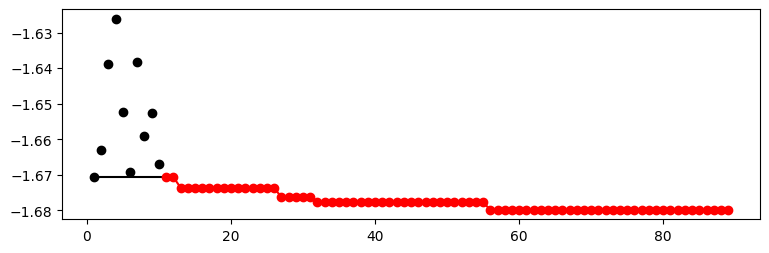

In [21]:
spot_tuner.plot_progress(log_y=False, filename="./figures/" + experiment_name+"_progress.pdf")

Results can also be printed in tabular form.


In [22]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name            | type   |   default |   lower |   upper |   tuned | transform   |   importance | stars   |
|-----------------|--------|-----------|---------|---------|---------|-------------|--------------|---------|
| n_estimators    | int    |      10.0 |     2.0 |    20.0 |    18.0 | None        |       100.00 | ***     |
| step            | float  |       1.0 |     0.5 |     2.0 |     0.5 | None        |         0.00 |         |
| use_aggregation | factor |       1.0 |     0.0 |     1.0 |     1.0 | None        |         0.00 |         |
| dirichlet       | float  |       0.5 |    0.01 |     1.0 |     1.0 | None        |         0.52 | .       |
| split_pure      | factor |       0.0 |     0.0 |     1.0 |     0.0 | None        |        57.65 | **      |


A histogram can be used to visualize the most important hyperparameters.


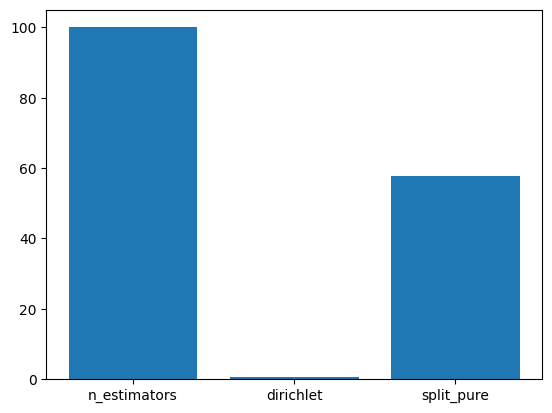

In [23]:
spot_tuner.plot_importance(threshold=0.0025, filename="./figures/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

The default hyperparameters, whihc will be used for a comparion with the tuned hyperparameters, can be obtained with the following commands:

In [24]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
model_default = get_one_core_model_from_X(X_start, fun_control)

:::{.callout-note}
#### Note: `spotPython` tunes numpy arrays
* `spotPython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.
::::

The model with the default hyperparameters can be trained and evaluated with the following commands:


In [25]:
from spotRiver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., space (metric), runtime, and memory consumption, can be visualized with the following commands:


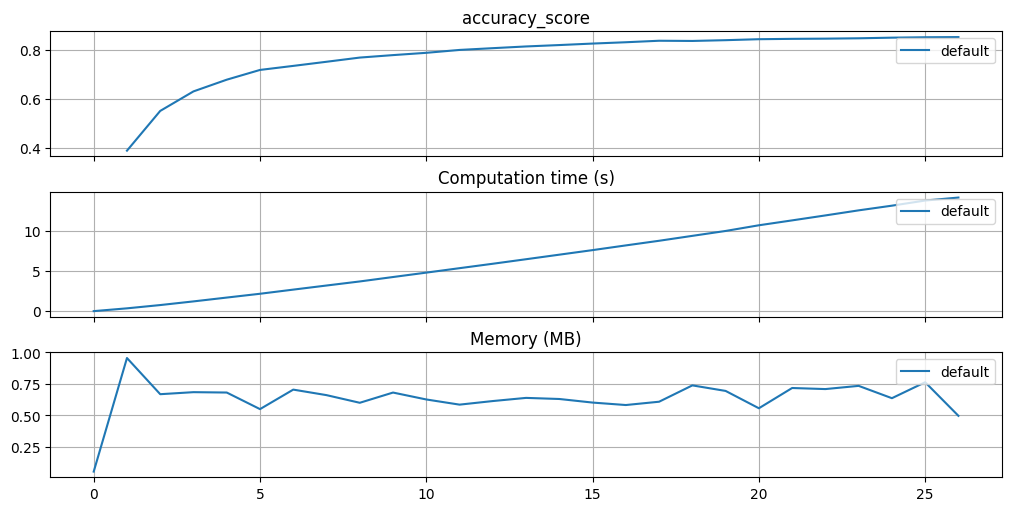

In [26]:
from spotRiver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

### Show Predictions

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.


In [27]:
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)

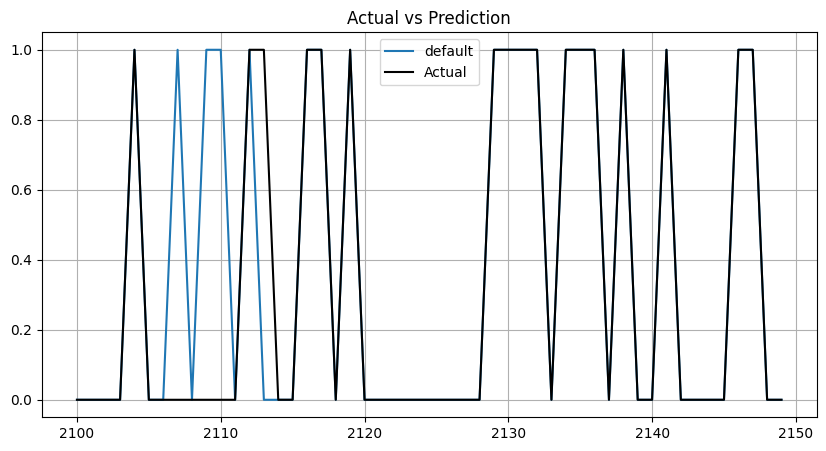

In [28]:
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotPython`.


In [29]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [30]:
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=fun_control["train"],
                    test=fun_control["test"],
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

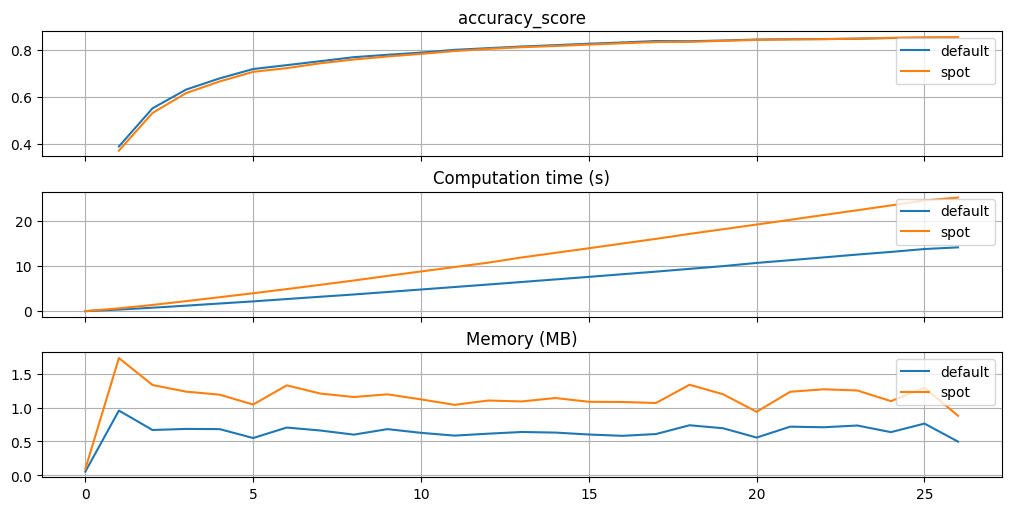

In [31]:
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"], filename="./figures/" + experiment_name+"_metrics.pdf")

In [32]:
# plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + experiment_name+"_predictions.pdf")

In [33]:
# from spotPython.plot.validation import plot_actual_vs_predicted
# plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
# plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Compare Predictions

In [34]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from spotPython.utils.convert import get_Xy_from_df
from typing import Any, Dict, List, Union
import pandas as pd


def plot_roc(
    model_list: List[pd.DataFrame],
    alpha: float = 0.8,
    model_names: List[str] = None,
) -> None:
    """
    Plot ROC curve for a list of models.

    Args:
        model_list: List of models.
        alpha: Transparency of the plotted lines.
        model_names: List of model names.
        
    Returns:
        None

    Examples:
        >>> from spotPython.utils.file import load_pickle
        >>> spot_tuner = load_pickle("spot_tuner")
        >>> plot_roc(model_list=[spot_tuner.df_eval], model_names=["SPOT"])
    """
    ax = plt.gca()
    for i, df in enumerate(model_list):
        y_test=df[target_column]
        y_pred=df["Prediction"]
        if model_names is not None:
            model_name = model_names[i]
        else:
            model_name = None        
        RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, alpha=alpha, name=model_name)
    plt.show()

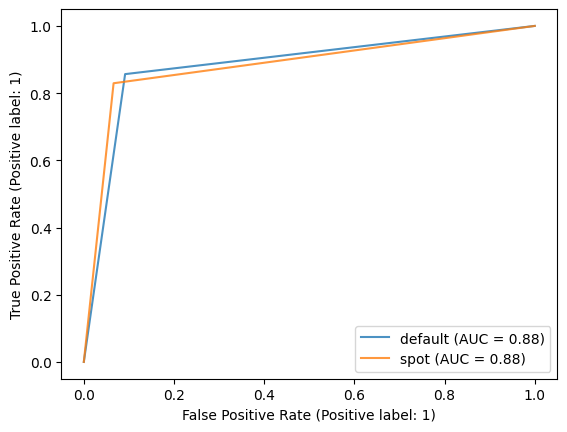

In [35]:
plot_roc([df_true_default, df_true_spot], model_names=["default", "spot"])

In [36]:
def plot_confusion_matrix(df, target_names=None, title=None):
    """
    Plotting a confusion matrix
    """
    y_test=df[target_column]
    pred=df["Prediction"]
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
    if target_names is not None:
        ax.xaxis.set_ticklabels(target_names)
        ax.yaxis.set_ticklabels(target_names)
    if title is not None:
        _ = ax.set_title(title)

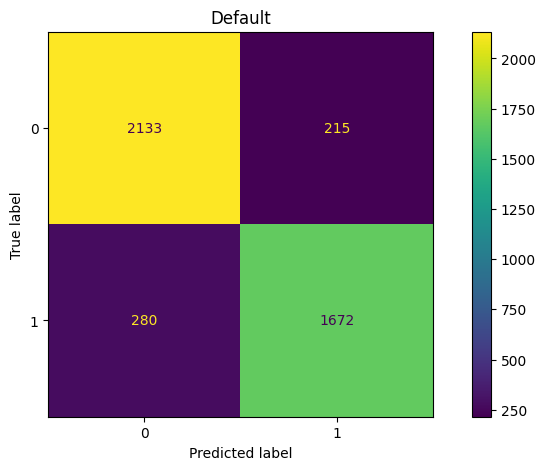

In [37]:
plot_confusion_matrix(df=df_true_default, title="Default")

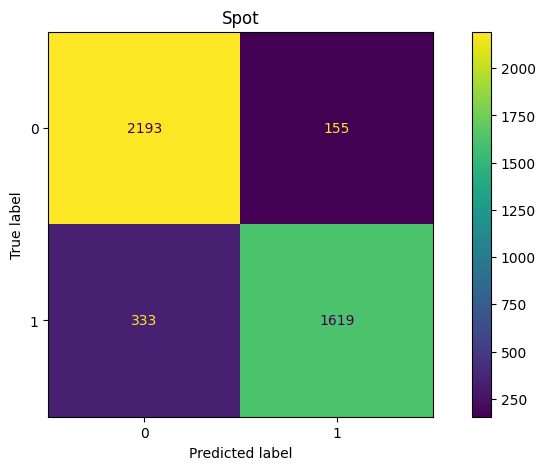

In [38]:
plot_confusion_matrix(df=df_true_spot, title="Spot")

## Detailed Hyperparameter Plots


n_estimators:  100.0
dirichlet:  0.520255909059878
split_pure:  57.64907787550189


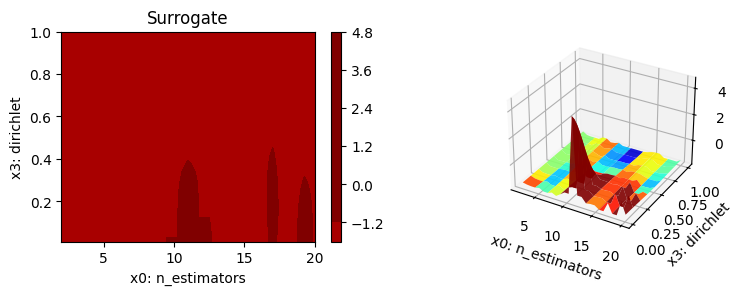

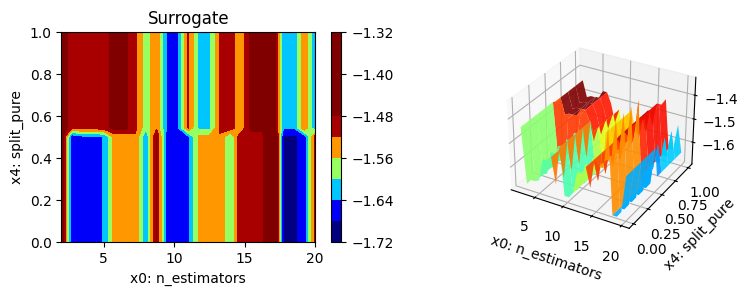

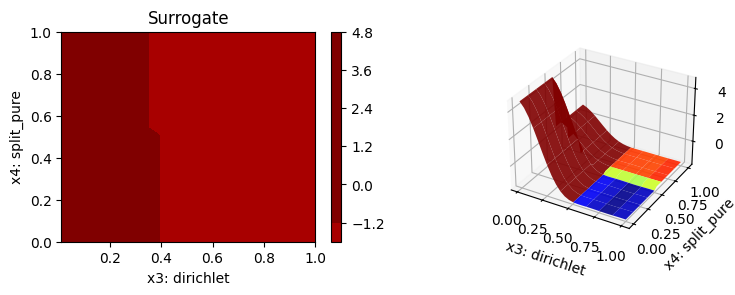

In [39]:
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

## Parallel Coordinates Plots


In [40]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.


In [41]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)